In [ ]:
from sktime.regression.distance_based import KNeighborsTimeSeriesRegressor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.stattools import adfuller
from sktime.split import temporal_train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import mutual_info_regression
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import GridSearchCV

In [703]:
names = ["Brazil", "Colombia", "Vietnam", "Indonesia", "Honduras"]
data_dict = {}  

for name in names:
    input_file = f"../clean_data/{name}_weather_cleaned.csv" 
    data_dict[name] = pd.read_csv(input_file)  

main_df = pd.read_csv("../clean_data/main_df_clean.csv")
Date = main_df["Date"]
y= main_df["Coffee"]

first_y_value = y[0]
last_y_value = y.iloc[-1]

main_df = main_df.drop(columns =  ["Date", "Coffee"])


In [704]:

adfuller(y)
# Fail to reject null, so there is evidence for unit root(non-stationarity)
y_diff = y.diff()
y_diff = y_diff.dropna()
y_diff = pd.Series(y_diff)

adfuller(y_diff)
# Reject null, so evidence for stationarity


(np.float64(-11.585252397836792),
 np.float64(2.877944863970424e-21),
 1,
 416,
 {'1%': np.float64(-3.4461675720270404),
  '5%': np.float64(-2.8685128587855955),
  '10%': np.float64(-2.5704843086630915)},
 np.float64(-636.9222622929537))

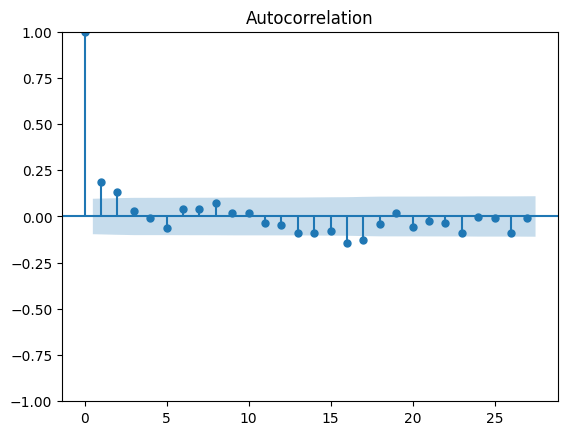

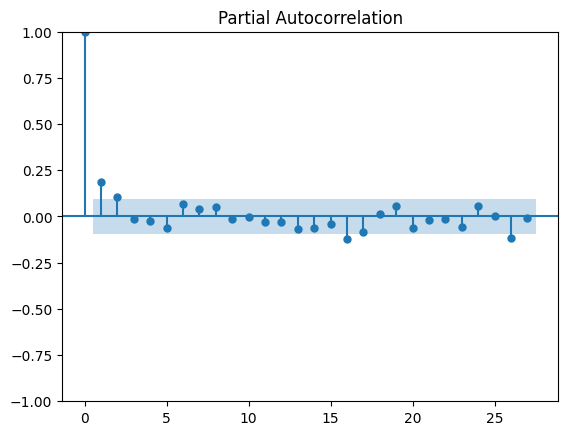

In [705]:
plot_acf(y_diff)
plot_pacf(y_diff)
plt.show()

In [706]:
stationary_cols = []
non_stationary_cols = []

for column in main_df.columns:
    result = adfuller(main_df[column])  
    p_value = result[1]
    
    
    if p_value < 0.05:
        stationary_cols.append(column)
    else:
        non_stationary_cols.append(column)
      
stationary_df = main_df[stationary_cols]
non_stationary_df = main_df[non_stationary_cols]
stationary_df

,Vietnam_temperature_2m_mean_vn,Vietnam_et0_fao_evapotranspiration_vn,Indonesia_temperature_2m_mean_in,Indonesia_et0_fao_evapotranspiration_in,Indonesia_precipitation_sum_in,Honduras_precipitation_sum_hon
0,21.289052,4.109480,25.252577,3.412106,6.867742,1.935484
1,22.938695,4.699384,25.438890,3.518966,8.982143,1.210714
2,24.077493,5.127649,25.706005,3.814265,9.561290,2.361290
3,25.045932,4.603029,26.231305,3.766648,6.286667,3.386667
4,24.485961,4.032747,26.307215,3.583512,5.732258,6.467742
...,...,...,...,...,...,...
414,22.884045,3.154708,26.897843,4.220664,3.645161,8.112903
415,24.035121,4.171292,28.485544,4.954863,1.296774,8.254839
416,23.041320,3.153404,27.723999,4.434608,6.356667,9.396667
417,22.559382,3.361497,27.594483,4.686166,4.106452,3.874194


In [707]:

y_lag = y_diff.shift(1).dropna().rename("Coffee_Lag_1")
y_lag_2 = y_lag.shift(1).dropna().rename("Coffee_Lag_2")
y_lag_3 = y_lag_2.shift(1).dropna().rename("Coffee_Lag_3")
non_stationary_df_diff = non_stationary_df.diff()
X = pd.concat([y_lag,y_lag_2, y_lag_3, stationary_df, non_stationary_df_diff], axis=1).dropna()
X

,Coffee_Lag_1,Coffee_Lag_2,Coffee_Lag_3,Vietnam_temperature_2m_mean_vn,Vietnam_et0_fao_evapotranspiration_vn,Indonesia_temperature_2m_mean_in,Indonesia_et0_fao_evapotranspiration_in,Indonesia_precipitation_sum_in,Honduras_precipitation_sum_hon,close,...,Milk,Tea,Colombia_temperature_2m_mean_col,Honduras_wind_speed_10m_max_hon,Colombia_precipitation_sum_col,Colombia_wind_speed_10m_max_col,Honduras_et0_fao_evapotranspiration_hon,Honduras_temperature_2m_mean_hon,Colombia_et0_fao_evapotranspiration_col,Vietnam_wind_speed_10m_max_vn
4,-0.002300,0.099500,0.081800,24.485961,4.032747,26.307215,3.583512,5.732258,6.467742,0.32,...,0.009868,-0.035335,-0.095741,-1.228709,4.913010,-0.130266,-0.028896,-0.526474,-0.024742,-2.859956
5,-0.017100,-0.002300,0.099500,23.156556,2.916088,26.039292,3.485836,3.490000,4.616667,-8.45,...,-0.002714,-0.025084,0.064422,-1.889366,1.750323,-0.288586,-0.699132,-1.028804,0.110460,6.995661
6,-0.037600,-0.017100,-0.002300,23.305248,3.465427,25.551570,3.569394,2.809677,4.577419,8.20,...,-0.002843,0.037648,-0.554678,0.807290,-5.630967,0.249388,0.293605,0.112407,0.328194,-1.280799
7,-0.017800,-0.037600,-0.017100,22.907802,3.024024,25.803385,3.879957,5.003226,8.229032,9.05,...,0.012950,-0.069128,0.127554,-0.022829,7.161288,0.595840,-0.279731,-0.299396,0.115126,1.670987
8,0.079400,-0.017800,-0.037600,23.065932,3.221849,26.249084,4.324088,2.916667,10.113333,-9.85,...,0.002517,0.048534,-0.052599,-1.101774,-7.936988,0.418219,-0.085092,0.237197,0.126617,-4.138048
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,0.160624,-0.075238,0.309530,22.884045,3.154708,26.897843,4.220664,3.645161,8.112903,2.40,...,0.003389,0.030359,0.466822,0.109079,-8.155915,1.330328,0.403202,-0.188627,0.573171,2.919395
415,0.086937,0.160624,-0.075238,24.035121,4.171292,28.485544,4.954863,1.296774,8.254839,14.85,...,0.002571,0.103634,-0.107393,0.569049,2.335484,-0.317732,0.400077,0.090457,0.131190,-5.436784
416,0.043390,0.086937,0.160624,23.041320,3.153404,27.723999,4.434608,6.356667,9.396667,26.20,...,0.006766,0.105838,0.906405,-4.390441,-2.879570,1.554439,-0.302391,0.216850,0.235555,3.140127
417,0.173227,0.043390,0.086937,22.559382,3.361497,27.594483,4.686166,4.106452,3.874194,-24.35,...,-0.012874,-0.082758,-1.046996,5.077178,6.927957,-1.541885,-0.700346,-1.005963,-0.592212,-0.300989


In [708]:
X, y_diff = X.align(y_diff, join='inner', axis=0)
mi_scores = mutual_info_regression(X, y_diff)
mi_scores_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)
non_zero_mi_scores = mi_scores_series[mi_scores_series > 0] 
X_filtered = X[non_zero_mi_scores.index]
X_filtered

,close,Sugar,Tea,Honduras_wind_speed_10m_max_hon,Indonesia_temperature_2m_mean_in,idr Exchange Rate,Coffee_Lag_1,Colombia_wind_speed_10m_max_col,Coffee_Lag_2,Honduras_precipitation_sum_hon,Vietnam_et0_fao_evapotranspiration_vn,Indonesia_precipitation_sum_in,brl Exchange Rate,Milk
4,0.32,-0.006200,-0.035335,-1.228709,26.307215,5.350000,-0.002300,-0.130266,0.099500,6.467742,4.032747,5.732258,0.000002,0.009868
5,-8.45,-0.016500,-0.025084,-1.889366,26.039292,9.600000,-0.017100,-0.288586,-0.002300,4.616667,2.916088,3.490000,0.000002,-0.002714
6,8.20,-0.009700,0.037648,0.807290,25.551570,5.960000,-0.037600,0.249388,-0.017100,4.577419,3.465427,2.809677,0.000004,-0.002843
7,9.05,-0.010700,-0.069128,-0.022829,25.803385,7.960000,-0.017800,0.595840,-0.037600,8.229032,3.024024,5.003226,0.000002,0.012950
8,-9.85,0.000900,0.048534,-1.101774,26.249084,5.430000,0.079400,0.418219,-0.017800,10.113333,3.221849,2.916667,0.000002,0.002517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414,2.40,0.001822,0.030359,0.109079,26.897843,-67.736063,0.160624,1.330328,-0.075238,8.112903,3.154708,3.645161,0.153073,0.003389
415,14.85,-0.009322,0.103634,0.569049,28.485544,-468.471008,0.086937,-0.317732,0.160624,8.254839,4.171292,1.296774,0.010566,0.002571
416,26.20,0.022052,0.105838,-4.390441,27.723999,-451.931818,0.043390,1.554439,0.086937,9.396667,3.153404,6.356667,-0.011047,0.006766
417,-24.35,0.017305,-0.082758,5.077178,27.594483,200.097826,0.173227,-1.541885,0.043390,3.874194,3.361497,4.106452,0.082542,-0.012874


In [712]:
X_train, X_test, y_train, y_test = temporal_train_test_split(X_filtered, y_diff, test_size=0.2)
last_y_t_value = y_train.iloc[-1]
print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
print(f"Train size: {len(y_train)}, Test size: {len(y_test)}")

Train size: 332, Test size: 83
Train size: 332, Test size: 83


In [713]:
scaler = StandardScaler()
X_scaled = scaler.fit(X_train)
X_train_trans = scaler.transform(X_train)
X_test_trans = scaler.transform(X_test)

In [714]:
knn = KNeighborsTimeSeriesRegressor()

param_grid = {
    'n_neighbors': np.arange(3, 22, 2),  
    'weights': ['uniform', 'distance'], 
    'distance_mtype': ['similarity', 'distance'],
    'distance': ['euclidean', 'dtw']
}
tscv = TimeSeriesSplit(n_splits=5)  
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=tscv, n_jobs=-1, verbose=1, scoring='neg_mean_squared_error')
grid_search.fit(X_train_trans , y_train)

print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)
print("All Results: ", grid_search.cv_results_)

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best Parameters:  {'distance': 'euclidean', 'distance_mtype': 'similarity', 'n_neighbors': np.int64(11), 'weights': 'distance'}
Best Score:  -0.009349501289950277
All Results:  {'mean_fit_time': array([0.88116865, 1.15388932, 1.09055138, 1.12828479, 0.003403  ,
       0.00390673, 0.00240073, 0.00347657, 0.00390892, 0.00480552,
       0.00640984, 0.00480947, 0.0051095 , 0.00470719, 0.00490742,
       0.0047287 , 0.00524631, 0.00480804, 0.00460601, 0.00470562,
       0.00430884, 0.00480094, 0.00470581, 0.00490227, 0.00530677,
       0.0037024 , 0.00530167, 0.00421696, 0.00470762, 0.00462584,
       0.00481281, 0.00450211, 0.00510635, 0.00440464, 0.00470381,
       0.00440392, 0.00470324, 0.00420108, 0.00491381, 0.00531087,
       0.00482111, 0.00480442, 0.00491323, 0.0053071 , 0.00480456,
       0.00412774, 0.00428495, 0.00490227, 0.0045042 , 0.00480957,
       0.00463672, 0.00453258, 0.00460496, 0.0047266 , 0.00510354,
      

c:\Users\Admin\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\ma\core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


In [715]:
knn_regressor =  KNeighborsTimeSeriesRegressor(n_neighbors= 11 ,distance_mtype= 'similarity', weights='distance', distance='euclidean')
knn_regressor.fit(X_train_trans , y_train)
y_hat_train = knn_regressor.predict(X_train_trans)
y_hat_test = knn_regressor.predict(X_test_trans)

In [716]:
y_train_orig = np.concatenate(([first_y_value], np.cumsum(y_train) + first_y_value))
y_test_orig = np.concatenate(([last_y_t_value], np.cumsum(y_test) + last_y_t_value))
y_hat_train_orig = np.concatenate(([first_y_value], np.cumsum(y_hat_train) + first_y_value))
y_hat_test_orig = np.concatenate(([last_y_t_value], np.cumsum(y_hat_test) + last_y_t_value))

train_mse = mean_squared_error(y_train_orig, y_hat_train_orig)
test_mse = mean_squared_error(y_test_orig, y_hat_test_orig)

print(train_mse)
print(test_mse)

0.0
0.5820081480795996


In [717]:
predicted_returns = np.concatenate([y_hat_train_orig, y_hat_test_orig])
returns_aligned = np.concatenate([y_train_orig, y_test_orig])

cumulative_actual = returns_aligned.cumsum() 
cumulative_predicted = predicted_returns.cumsum()

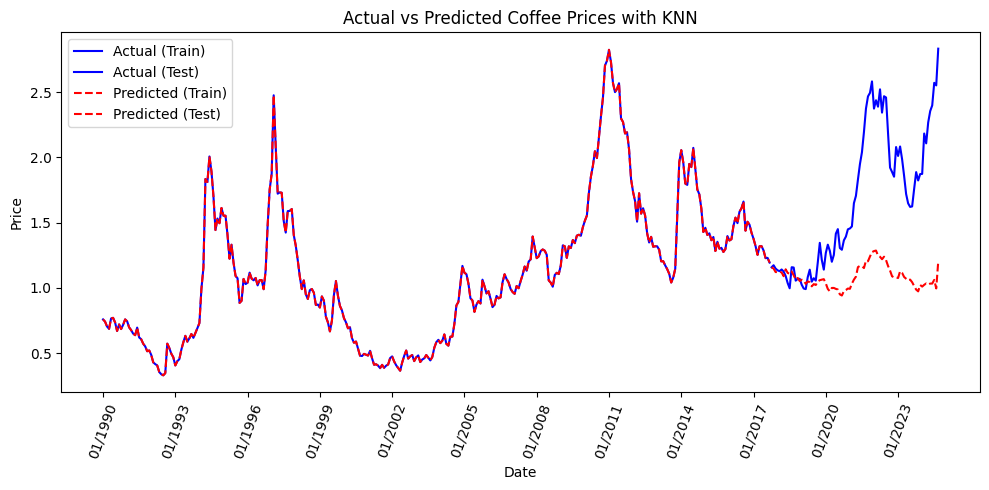

In [718]:

new_main_df = pd.concat([Date , main_df], axis = 1)


train_dates = new_main_df.iloc[:len(y_train_orig)]['Date']  
test_dates = new_main_df.iloc[len(y_train_orig):len(y_train_orig) + len(y_test_orig)]['Date']  

plt.figure(figsize=(10, 5))


plt.plot(train_dates, y_train_orig, label="Actual (Train)", color="blue")

plt.plot(test_dates, y_test_orig + y_train_orig[-1], label="Actual (Test)", color="blue")


plt.plot(train_dates, predicted_returns[:len(y_train_orig)], label="Predicted (Train)", color="red", linestyle="--")

plt.plot(test_dates, predicted_returns[len(y_train_orig):len(y_train_orig) + len(y_test_orig)] + y_train_orig[-1], label="Predicted (Test)", color="red", linestyle="--")

plt.title("Actual vs Predicted Coffee Prices with KNN")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()


tick_interval = 36
plt.xticks(range(0,len(main_df), tick_interval), rotation = 70)  
plt.tight_layout()  
plt.show()
